In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
from paf_loader import Loader, load_confidence_map_and_paf
import numpy as np
import cv2
from cselect import color as cs
from time import time
import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.evaluation import pcp
from mvpose import settings
from os.path import isfile, join

data_root = Settings['data_root']

params = settings.get_settings(scale_to_mm=1000,
                               min_nbr_joints=5,
                               max_epi_distance=25)

import mvpose.data.skeleton_augmentation as ska
model_path = '../data/model_poseprediction.h5'
gen = ska.LimbGenerator(model_path, params.scale_to_mm)

# ----------------------------------
# ==================================
# default
seq1_zipname = 'player2sequence1.zip'
seq1_dir = 'Sequence 1'
# ----------------------------------


# seq1_zipname = 'player2sequence2.zip'
# seq1_dir = 'Sequence 2'
# ==================================
# ----------------------------------


# ====================================================
# Extractor Functions
# ====================================================
def extract_best(pos3d, Humans, alpha):
    """
        Extracts the best fitting human for the calculation
    """
    larms = 0
    uarms = 0
    ulegs = 0
    llegs = 0
    all_parts = 0
    
    for h in Humans:
        r = pcp.evaluate(pos3d, Humans[0], alpha)
        if all_parts < r.all_parts:
            larms = r.lower_arms
            uarms = r.upper_arms
            ulegs = r.upper_legs
            llegs = r.lower_legs
    
    return {
        "larms": larms,
        "uarms": uarms,
        "ulegs": ulegs,
        "llegs": llegs
    }


OBJECTIVE_VALUES = []
CENTERS_3D = []
LIMBS = []
PEAKS_3D = []


def apply(frame, alpha, loader):
    """
    """
    global OBJECTIVE_VALUES, CENTERS_3D
    global seq1_zipname
    global seq1_zip
    global EXP_NBR
    Im, Calib, pos2d, pos3d = kth.get(
        data_root, seq1_zipname, seq1_dir, frame, player=2)
    heatmaps, pafs = loader.load_confidence_map_and_paf(
        'kth' + seq1_zipname[0:-4], Im, frame, dir=Settings['tmp'])
    
    
#     fname = join('/tmp', EXP_NBR + "_frame" + str(frame) + '.npy')
#     if isfile(fname):
#         detections = np.load(fname)
#     else:
    detections, obj_value, centers3d, limbs3d, peaks3d = pose.estimate(Calib, heatmaps, pafs, 
                           settings=params)
    CENTERS_3D.append(centers3d)
    OBJECTIVE_VALUES.append(obj_value)
    LIMBS.append(limbs3d)
    PEAKS_3D.append(peaks3d)
#         np.save(fname, detections)
    
    detections = gen.apply(detections)
    
    Humans = kth.transform3d_from_mscoco(detections)
    result1 = extract_best(pos3d, Humans, alpha)
    
    # ---------------------------------
    
    
#     detections = gen.apply(detections)
#     Humans = kth.transform3d_from_mscoco(detections)
#     result2 = extract_best(pos3d, Humans, alpha)
    
    del Im
    del Calib
    del pos2d
    del pos3d
    del heatmaps
    del pafs
    del detections
    del Humans
    
    #return result1, result2
    return result1

/home/tanke/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def run_experiment():
    
    loader = Loader(with_gpu=True)

    alpha = 0.5

    larms = []
    uarms = []
    llegs = []
    ulegs = []

    # 0 .. 214
    for frame in range(0, 214):
        _start = time()
        result = apply(frame, alpha, loader)
        larms.append(result['larms'])
        uarms.append(result['uarms'])
        llegs.append(result['llegs'])
        ulegs.append(result['ulegs'])

        _end = time()
        print('frame ' + str(frame) + ', elapsed', _end - _start)
    
    return larms, uarms, llegs, ulegs

larms, uarms, llegs, ulegs = run_experiment()

frame 0, elapsed 4.604252815246582
frame 1, elapsed 2.5281271934509277
frame 2, elapsed 2.479008913040161
frame 3, elapsed 2.5415594577789307
frame 4, elapsed 2.6573145389556885
frame 5, elapsed 3.1725406646728516
frame 6, elapsed 2.527852773666382
frame 7, elapsed 2.60422420501709
frame 8, elapsed 2.50864315032959
frame 9, elapsed 2.4699807167053223
frame 10, elapsed 2.494508981704712
frame 11, elapsed 2.4918904304504395
frame 12, elapsed 2.594040632247925
frame 13, elapsed 2.661541700363159
frame 14, elapsed 2.601200580596924
frame 15, elapsed 2.491183280944824
frame 16, elapsed 2.750678300857544
frame 17, elapsed 2.486664056777954
frame 18, elapsed 2.451378345489502
frame 19, elapsed 2.41532301902771
frame 20, elapsed 2.4602904319763184
frame 21, elapsed 2.573620080947876
frame 22, elapsed 2.461203098297119
frame 23, elapsed 2.488917589187622
frame 24, elapsed 2.4273035526275635
frame 25, elapsed 2.3983216285705566
frame 26, elapsed 2.5979056358337402
frame 27, elapsed 2.45041298866

## No unary (simple)
* upper arms:	 0.955607476635514
* lower arms:	 0.822429906542056
* upper legs:	 0.9439252336448598
* lower legs:	 0.883177570093458

# With unary (simple)
* upper arms:	 0.955607476635514
* lower arms:	 0.8247663551401869
* upper legs:	 0.9439252336448598
* lower legs:	 0.897196261682243

# Like in Master thesis with Xi = 0
* upper arms:	 0.9532710280373832
* lower arms:	 0.7990654205607477
* upper legs:	 0.9602803738317757
* lower legs:	 0.9345794392523364

# Like in Master thesis with Xi = 0.5
* upper arms:	 0.955607476635514
* lower arms:	 0.8271028037383178
* upper legs:	 0.9439252336448598
* lower legs:	 0.9065420560747663

# Like in Master thesis with Xi = 0.7 (x)
* upper arms:	 0.9532710280373832
* lower arms:	 0.8341121495327103
* upper legs:	 0.9485981308411215
* lower legs:	 0.9135514018691588
* avg:		 0.9123831775700935

# Like in Master thesis without unary
* upper arms:	 0.9532710280373832
* lower arms:	 0.8341121495327103
* upper legs:	 0.9462616822429907
* lower legs:	 0.8995327102803738
* avg:		 0.9082943925233645

# Like in Master thesis with Xi = 0.7 and PC
* upper arms:	 0.9602803738317757
* lower arms:	 0.9088785046728972
* upper legs:	 0.9509345794392523
* lower legs:	 0.9182242990654206
* avg:		 0.9345794392523366

# Like in Master thesis with Xi = 0.7 and PC and log
* upper arms:	 0.9485981308411215
* lower arms:	 0.8855140186915887
* upper legs:	 0.9532710280373832
* lower legs:	 0.9042056074766355
* avg:		 0.9228971962616822

In [3]:
print("upper arms:\t", np.mean(uarms))
print("lower arms:\t", np.mean(larms))
print("upper legs:\t", np.mean(ulegs))
print("lower legs:\t", np.mean(llegs))
print('avg:\t\t', np.mean([
    np.mean(uarms), np.mean(larms), np.mean(ulegs), np.mean(llegs)
]))

upper arms:	 0.9602803738317757
lower arms:	 0.9135514018691588
upper legs:	 0.9462616822429907
lower legs:	 0.9088785046728972
avg:		 0.9322429906542057


In [4]:
#np.save('demo1_obj.npy', OBJECTIVE_VALUES)

OBJECTIVE_VALUES_old = np.load('demo1_obj.npy')
DIV = np.abs(OBJECTIVE_VALUES - OBJECTIVE_VALUES_old)
print(np.sum(DIV))

# for i, (a, b) in enumerate(zip(OBJECTIVE_VALUES, OBJECTIVE_VALUES_old)):
#     print('frame ' + str(i) + " div:" + str(abs(a-b)) + " --> ", (a, b))

0.3064582608803619


In [5]:
# np.save('demo1_centers3d.npy', CENTERS_3D)
# np.save('demo1_peaks3d.npy', PEAKS_3D)
# np.save('demo1_limbs.npy', LIMBS)

CENTERS_3D_old = np.load('demo1_centers3d.npy')
LIMBS_old = np.load('demo1_limbs.npy')
PEAKS_3D_old = np.load('demo1_peaks3d.npy')

def compare(A, B):
    for a, b in zip(A, B):
        if len(a) != len(b):
            return False
        for left, right in zip(a, b):
            for l, r in zip(left, right):
                if abs(l -r ) > 0.0001:
                    return False

    return True
  
    
print('PEAKS:')
CC = []
for centers3d_old, centers3d in zip(PEAKS_3D_old, PEAKS_3D):
    if compare(centers3d_old, centers3d):
        CC.append(0)
    else:
        CC.append(1)
print('\terrors:', np.sum(CC))
    
print('CENTERS:')
CC = []
for centers3d_old, centers3d in zip(CENTERS_3D_old, CENTERS_3D):
    if compare(centers3d_old, centers3d):
        CC.append(0)
    else:
        CC.append(1)
print('\terrors:', np.sum(CC))
    
print('LIMBS:')
CC = []
for limbs3d_old, limbs3d in zip(LIMBS_old, LIMBS):
    if compare(limbs3d_old, limbs3d):
        CC.append(0)
    else:
        CC.append(1)
print('\terrors:', np.sum(CC))

PEAKS:
	errors: 3
CENTERS:
	errors: 3
LIMBS:
	errors: 2


FileNotFoundError: [Errno 2] No such file or directory: 'demo1_mu.npy'

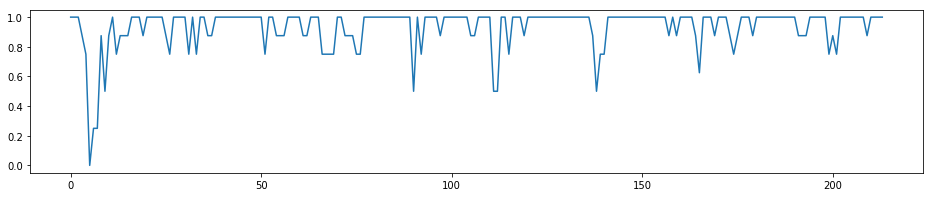

In [6]:
fig = plt.figure(figsize=(16,3))
ax = fig.add_subplot(111)
x = range(0, len(uarms))

# ax.plot(x, uarms, label='uarms')
# ax.plot(x, larms, label='larms')
# ax.plot(x, ulegs, label='ulegs')
# ax.plot(x, llegs, label='llegs')

mu = np.mean([uarms, larms, ulegs, llegs], axis=0)
ax.plot(x, mu)


#np.save('demo1_mu.npy', mu)
mu_old = np.load('demo1_mu.npy')
DIV = np.abs(mu - mu_old)
print("div", np.sum(DIV))


ax.set_xlim([0, 214])
ax.set_ylim([0, 1.01])

#plt.legend()
plt.show()

In [ ]:
from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human

frame = 5
tmp = '/tmp'

print('mu at frame ' + str(frame) + ":", mu[frame])

Im, Calib, pos2d, pos3d = kth.get(
    data_root, seq1_zipname, seq1_dir, frame, player=2)
heatmaps, pafs = load_confidence_map_and_paf(
    'kth' + seq1_zipname[0:-4], Im, frame, dir=tmp)
_start = time()
Debug, detections = pose.estimate(Calib, heatmaps, pafs,
                                  settings=params, debug=True)


Humans = detections

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1,3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
    
plt.show()

In [ ]:
colors = cs.lincolor(20)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1, 3, cid+1)
    ax.axis('off')
    ax.set_xlim([0, 480])
    ax.set_ylim([640, 0])
    ax.imshow(im, alpha=0.5)
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers2d_with_w = Debug.candidates2d.peaks2d[cid][jid]
        if len(centers2d_with_w) == 0:
            continue
        centers2d = centers2d_with_w[:,0:2].astype('float32')
        score = centers2d_with_w[:,2]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color=colors[jid], s=score*50, alpha=0.8)
    
plt.show()

In [ ]:
colors = cs.lincolor(20)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1, 3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers3d_with_w = Debug.triangulation.peaks3d_weighted[jid]
        centers3d = centers3d_with_w[:,0:3].astype('float32')
        centers2d = cam.projectPoints(centers3d)
        score = centers3d_with_w[:,3]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color=colors[jid], s=score*50, alpha=0.8)
                #ax.text(x, y, str(jid))
    
plt.show()

In [ ]:
colors = cs.lincolor(20)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1, 3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers3d_with_w = Debug.meanshift.centers3d[jid]
        centers3d = centers3d_with_w[:,0:3].astype('float32')
        centers2d = cam.projectPoints(centers3d)
        score = centers3d_with_w[:,3]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color=colors[jid], s=score*50, alpha=0.8)
                #ax.text(x, y, str(jid))
    
plt.show()

In [ ]:
from mvpose.data.default_limbs import DEFAULT_LIMB_SEQ

# left leg = 11
# right arm = 2,3
# left arm = 4,5
LIMB_ID = 4
a,b = DEFAULT_LIMB_SEQ[LIMB_ID]

W = Debug.limbs3d[LIMB_ID]
n,m = W.shape

candA = Debug.meanshift.centers3d[a][:,0:3]
candB = Debug.meanshift.centers3d[b][:,0:3]
assert n == len(candA) and m == len(candB)

fig = plt.figure(figsize=(16,12))


for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1, 3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
    ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)
    
    ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='orange', alpha=0.5)
    ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='blue', alpha=0.5)
    
    sq_maskA = np.squeeze(maskA[0])
    sq_maskB = np.squeeze(maskB[0])
    if len(sq_maskA.shape) == 0:
        sq_maskA = np.expand_dims(sq_maskA, axis=0)
    if len(sq_maskB.shape) == 0:
        sq_maskB = np.expand_dims(sq_maskB, axis=0)
    
    for _a in sq_maskA:
        for _b in sq_maskB:
            w = W[_a,_b]
            Ax,Ay = ptsA2d[_a]
            Bx,By = ptsB2d[_b]
            if w > 0:
                ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*10, alpha=0.4)
            elif w > -99999:
                ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*10, alpha=0.4)

plt.show()

In [ ]:
import numpy.linalg as la

fig = plt.figure(figsize=(16,12))

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1, 3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    for lid, (a, b) in enumerate(DEFAULT_LIMB_SEQ):
        candA = Debug.meanshift.centers3d[a][:,0:3]
        candB = Debug.meanshift.centers3d[b][:,0:3]
        W = Debug.limbs3d[lid]
        n, m = W.shape
        assert n == len(candA) and m == len(candB)
        
        ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
        ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)

        ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='black', alpha=0.2)
        ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='black', alpha=0.2)
        
        sq_maskA = np.squeeze(maskA[0])
        sq_maskB = np.squeeze(maskB[0])
        if len(sq_maskA.shape) == 0:
            sq_maskA = np.expand_dims(sq_maskA, axis=0)
        if len(sq_maskB.shape) == 0:
            sq_maskB = np.expand_dims(sq_maskB, axis=0)
        
        min_length, max_length = params.sensible_limb_length[lid]
        
        for _a in sq_maskA:
            for _b in sq_maskB:
                p3dA = candA[_a]
                p3dB = candB[_b]
                distance = la.norm(p3dA - p3dB)
                lstype = '-'
                if distance < min_length or distance > max_length:
                    lstype = ':'
                    
                w = W[_a,_b]
                Ax,Ay = ptsA2d[_a]
                Bx,By = ptsB2d[_b]
                if w > 0:
                    ax.plot([Ax,Bx], [Ay,By], color='green', 
                            linestyle=lstype, linewidth=w*10, alpha=0.4)
                elif w > -99999:
                    ax.plot([Ax,Bx], [Ay,By], color='red', 
                            linestyle=lstype, linewidth=-w*10, alpha=0.4)

plt.show()